In [1]:
# a more systematic notebook on filtering.  

# online bible of digital filter mathematics: 
# https://ccrma.stanford.edu/~jos/Welcome.html

# but we start simply with 
# https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

In [54]:
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy import fftpack as spfft # for computing spectra

import matplotlib.pyplot as plt
import IPython.display as ipd

%matplotlib inline
pi = np.pi

In [20]:
# First make some data to be filtered.
dur0 = 5.0         # seconds
fs = 44100       # sample rate, Hz
npts = int(dur0 * fs) # total number of samples
time = np.linspace(0, dur0, npts) # this is not necessary

freq0 = 110.0 
n_cycles = dur0*freq0
rads = np.linspace(0,2*pi*n_cycles,npts)
sound = np.sin(rads)
freq_rats = np.linspace(1,4.3,11)

for f_rat in freq_rats:
    n_cycles = dur0*freq0*f_rat
    rads = np.linspace(0,2*pi*n_cycles,npts)
    y = np.sin(rads)
    sound = sound + y

sound = sound/max(sound)
    
    # and some white noise: 


In [33]:
# calculate the fourier spectra: (see s00_make_simple_sounds.ipynb for more on this). 
Nfft = int(len(sound)/2) 
f = np.arange(-Nfft/2,Nfft/2,1)*fs/Nfft 
S = spfft.fft(sound, n=Nfft)
# Let's consider only positive frequencies
f = f[int(len(f)/2):] 
S = S[:int(len(S)/2)] 
# Now f covers the (discretized) frequency range from 0 to sr/2 Hz (see Nyquist theorem, Nyquist frequency)


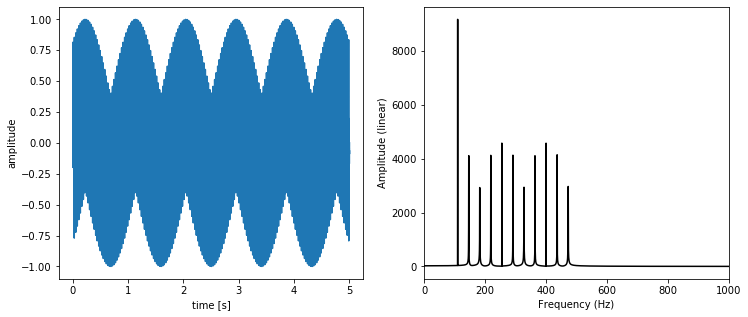

In [37]:

plt.subplots(1,2,figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(time,sound) #[1000:20000])
plt.xlabel('time [s]')
plt.ylabel('amplitude')

plt.subplot(1,2,2)
plt.plot(f,np.absolute(S),'k') # Since S is complex-valued, we have to choose between the absolute value and phase
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (linear)')
plt.xlim([0,1000])


a_scale = 0.8
ipd.Audio(sound*a_scale, rate=fs)


# Butterworth filter (low pass)

In [59]:
# define the filter functions: 

# Butterworth Lowpass
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    #y = filtfilt(b, a, data)
    return y

# Butterworth Bandpass
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
# https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter?noredirect=1&lq=1

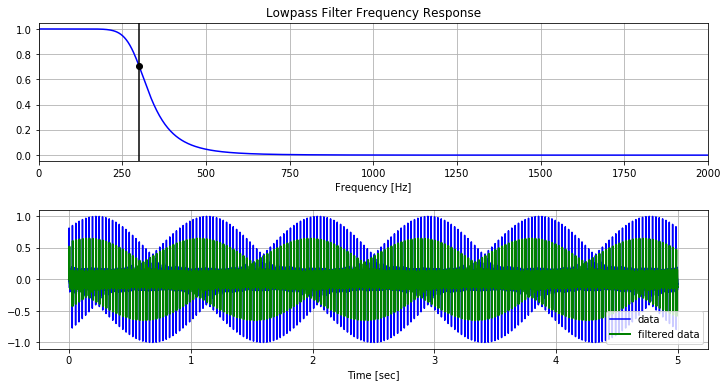

In [60]:
# Filter requirements.
order = 6

cutoff = 300  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

# Filter the data, and plot both the original and filtered signals.
sound_filt = butter_lowpass_filter(sound, cutoff, fs, order)

# PLOT
# filter shape
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 2000) #0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filtered and raw
plt.subplot(2, 1, 2)
plt.plot(time, sound, 'b-', label='data')
plt.plot(time, sound_filt, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [61]:
ipd.Audio(sound*a_scale, rate=fs)

In [62]:
ipd.Audio(sound_filt*a_scale, rate=fs)

# Finite Impulse Response filter (lowpass) 
More flexibility than a butterworth <br>
https://scipy-cookbook.readthedocs.io/items/FIRFilter.html <br>

In [90]:
from scipy.signal import kaiserord, firwin, sosfiltfilt

In [124]:
#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------
cutoff_hz = 247.0 # 230.0
width_fac = 44.0

# The Nyquist rate of the signal.
nyq_rate = fs / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = width_fac/nyq_rate # must be larger than about 5, 
# larger number = fewer filter coefficients (taps), less rapid taper

# The desired attenuation in the stop band, in dB.
ripple_db = 10.0 # smaller number, more taps

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
#cutoff_hz = 230.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
print(len(taps))
# Use lfilter to filter x with the FIR filter.
#filtered_x = lfilter(taps, 1.0, x)
#sound_filt_FIR = lfilter(taps, 1.0, sound) # what is the 1.0 ? 
sound_filt_FIR = filtfilt(taps, 1.0, sound) # what is the 1.0 ? a normalization or scaling in the denominator?

145


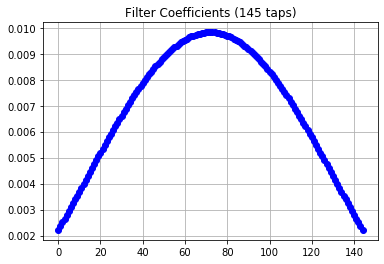

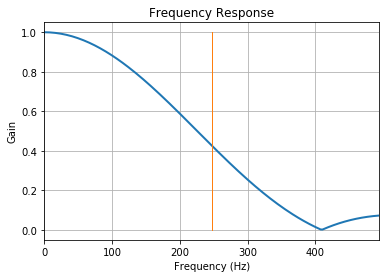

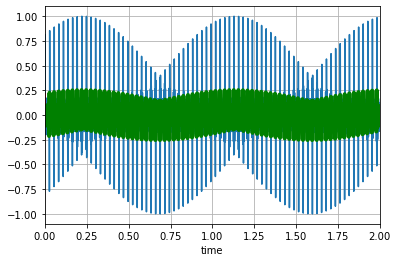

In [125]:
#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

plt.figure(1)
plt.plot(taps, 'bo-', linewidth=2)
plt.title('Filter Coefficients (%d taps)' % N)
plt.grid(True)

#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

plt.figure(2)
w, h = freqz(taps, worN=8000)
#print(len(w),len(h))
plt.plot((w/pi)*nyq_rate, np.absolute(h), linewidth=2)
plt.plot([cutoff_hz,cutoff_hz],[0,1],linewidth=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.xlim(0, 2*cutoff_hz)
plt.ylim(-0.05, 1.05)
plt.grid(True)

# # Upper inset plot.
# ax1 = axes([0.42, 0.6, .45, .25])
# plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
# xlim(0,8.0)
# ylim(0.9985, 1.001)
# grid(True)

# # Lower inset plot
# ax2 = axes([0.42, 0.25, .45, .25])
# plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
# xlim(12.0, 20.0)
# ylim(0.0, 0.0025)
# grid(True)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / fs

plt.figure(3)
# Plot the original signal.
plt.plot(time, sound)
# Plot the filtered signal, shifted to compensate for the phase delay.
plt.plot(time-delay, sound_filt_FIR , 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plt.plot(time[N-1:]-delay, sound_filt_FIR[N-1:], 'g', linewidth=4)

plt.xlim(0,2)
plt.xlabel('time')
plt.grid(True)

plt.show()

In [ ]:
https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html